In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sklearn

In [3]:
from sklearn.datasets import make_circles

In [4]:
n_samples = 1000
x, y = make_circles(n_samples, noise=0.03)

In [5]:
for e in range(10):
    print(f'{x[e]} | {y[e]}')

[ 0.84702317 -0.15919749] | 1
[ 0.58775623 -0.51093387] | 1
[-0.74273838 -0.67249089] | 0
[0.45027842 0.70684768] | 1
[ 0.44071355 -0.67362733] | 1
[-0.92508618  0.24335672] | 0
[-0.32362683 -0.99428059] | 0
[ 0.61338869 -0.38203076] | 1
[0.7290698  0.42619183] | 1
[ 0.8015033 -0.1804591] | 1


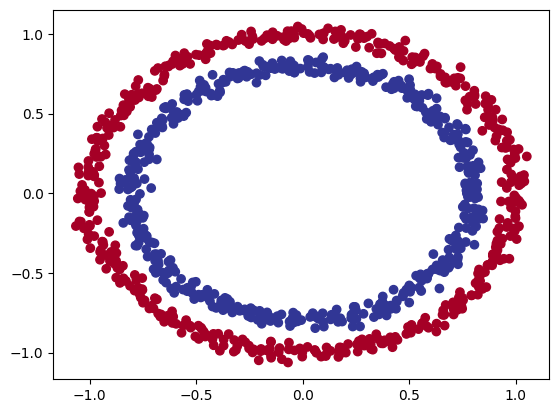

In [6]:
plt.scatter(x = x[:,0],
            y = x[:,1],
            c = y,
            cmap = plt.cm.RdYlBu)

input and output shapes

In [7]:
x.shape, y.shape

((1000, 2), (1000,))

turn into tensors

In [8]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
x[:5], y[:5]

(tensor([[ 0.8470, -0.1592],
         [ 0.5878, -0.5109],
         [-0.7427, -0.6725],
         [ 0.4503,  0.7068],
         [ 0.4407, -0.6736]]),
 tensor([1., 1., 0., 1., 1.]))

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [11]:
len(x_train), len(x_test)

(800, 200)

In [12]:
x_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [13]:
class CircleModelV0(nn.Module):
    def init(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model0 = CircleModelV0()

In [14]:
model0

CircleModelV0()

In [15]:
model1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
)

In [16]:
model1

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
model1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2755,  0.3909],
                      [-0.0464, -0.0251],
                      [-0.6324, -0.4241],
                      [ 0.1262,  0.3709],
                      [ 0.3066,  0.2818],
                      [-0.1796, -0.4231],
                      [-0.1359, -0.4067],
                      [-0.2682, -0.6188]])),
             ('0.bias',
              tensor([ 0.6242,  0.0752, -0.4645, -0.5523, -0.3430,  0.1856,  0.0856,  0.0758])),
             ('1.weight',
              tensor([[ 0.2347, -0.2343, -0.2468, -0.2033, -0.1176, -0.1042, -0.1142, -0.2110]])),
             ('1.bias', tensor([0.2771]))])

In [18]:
with torch.inference_mode():
    untrained_preds = model1(x_test)
y_train[:5], untrained_preds[:5]

(tensor([1., 0., 1., 0., 1.]),
 tensor([[0.9942],
         [0.7741],
         [0.9798],
         [0.9781],
         [0.9385]]))

binary cross entropy or categorical cross entropy (to multiclass)

sgd or adam

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)

In [20]:
#calculate accuracy - out of 100 ex, what the percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [21]:
accuracy_fn(y_true=y_test, y_pred=untrained_preds)

0.0

In [22]:
#use sigmoid activation func to make predictions probabilities
y_pred_probs = torch.sigmoid(untrained_preds)
y_pred_probs[:5]

tensor([[0.7299],
        [0.6844],
        [0.7271],
        [0.7267],
        [0.7188]])

In [23]:
torch.round(y_pred_probs)[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

if less than 0.5, y = 0
if more, y = 1

In [24]:
epochs = 100

for epoch in range(epochs):
    model1.train()

    y_logits = model1(x_train).squeeze()
    y_pred_act = torch.round(torch.sigmoid(y_logits)) #turn logits -> pred probs - pred labels
    
    loss = loss_fn(y_logits, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model1.eval()
            
    if epoch % 10 == 0:
        with torch.inference_mode():
            test_logits = model1(x_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss} | Acc: {test_acc}")
        print("--//--")

Epoch: 0 | Loss: 0.760169506072998 | Test loss: 0.706615149974823 | Acc: 56.99999999999999
--//--
Epoch: 10 | Loss: 0.7534645199775696 | Test loss: 0.7032834887504578 | Acc: 56.99999999999999
--//--
Epoch: 20 | Loss: 0.7474777102470398 | Test loss: 0.7004644870758057 | Acc: 56.99999999999999
--//--
Epoch: 30 | Loss: 0.7421266436576843 | Test loss: 0.6980910301208496 | Acc: 56.99999999999999
--//--
Epoch: 40 | Loss: 0.7373390793800354 | Test loss: 0.6961045861244202 | Acc: 56.99999999999999
--//--
Epoch: 50 | Loss: 0.7330516576766968 | Test loss: 0.6944538950920105 | Acc: 56.99999999999999
--//--
Epoch: 60 | Loss: 0.7292085886001587 | Test loss: 0.6930946111679077 | Acc: 56.99999999999999
--//--
Epoch: 70 | Loss: 0.725760817527771 | Test loss: 0.691987931728363 | Acc: 56.99999999999999
--//--
Epoch: 80 | Loss: 0.7226649522781372 | Test loss: 0.6911000609397888 | Acc: 56.99999999999999
--//--
Epoch: 90 | Loss: 0.7198827862739563 | Test loss: 0.6904011368751526 | Acc: 56.99999999999999
--

In [46]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model2 = CircleModelV2()
print(model2)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [44]:
model2.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2632,  0.3521],
                      [-0.0209, -0.3067],
                      [ 0.3800, -0.1224],
                      [-0.6450,  0.0009],
                      [ 0.6446,  0.6798],
                      [ 0.6013,  0.3960],
                      [-0.0042, -0.4830],
                      [ 0.5033,  0.5094],
                      [-0.2246,  0.3123],
                      [-0.0572, -0.2869]])),
             ('layer_1.bias',
              tensor([ 0.5608, -0.6658, -0.2128, -0.3744,  0.4538,  0.4980,  0.5422,  0.4039,
                      -0.0785,  0.5806])),
             ('layer_2.weight',
              tensor([[ 0.1904, -0.1938, -0.0047, -0.2702, -0.2313,  0.2110, -0.1421,  0.1607,
                        0.0174,  0.1536],
                      [ 0.1650,  0.3085,  0.2634,  0.0727,  0.2445,  0.1697,  0.0244, -0.1496,
                        0.2717, -0.0580],
                      [ 0.2418, -0.1584, -0.2041,  0.0010, -0.2647,  0.2

In [47]:
new_loss_fn = nn.BCEWithLogitsLoss()
new_optimzer = torch.optim.SGD(params = model2.parameters(), lr=0.1)

In [ ]:
model2(x_train[0]).squeeze()

tensor(0., grad_fn=<SqueezeBackward0>)

In [51]:
epochs = 1000

for epoch in range(epochs):
    y_logits = model2(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = new_loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    new_optimzer.zero_grad()
    
    loss.backward()
    
    new_optimzer.step()
    
    model2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model2(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.28478, Accuracy: 99.88% | Test Loss: 0.29270, Test Accuracy: 99.00%
Epoch: 100 | Loss: 0.16648, Accuracy: 100.00% | Test Loss: 0.17087, Test Accuracy: 99.50%
Epoch: 200 | Loss: 0.10139, Accuracy: 100.00% | Test Loss: 0.10344, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.06757, Accuracy: 100.00% | Test Loss: 0.06896, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.04885, Accuracy: 100.00% | Test Loss: 0.05029, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.03752, Accuracy: 100.00% | Test Loss: 0.03896, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.03012, Accuracy: 100.00% | Test Loss: 0.03146, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.02497, Accuracy: 100.00% | Test Loss: 0.02620, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.02123, Accuracy: 100.00% | Test Loss: 0.02239, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.01841, Accuracy: 100.00% | Test Loss: 0.01954, Test Accuracy: 100.00%


In [53]:
# Make predictions
model2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model2(x_test))).squeeze()
y_preds[:10], y_test[:10] # want preds in same format as truth labels

(tensor([0., 0., 0., 0., 1., 1., 1., 0., 1., 0.]),
 tensor([0., 0., 0., 0., 1., 1., 1., 0., 1., 0.]))